#ANÁLISE DE ETF NO MERCADO BRASILEIRO COM ML

Cássia Chin Bo Hing



(Análise de Exchange-Traded Fund no Mercado Brasileiro 
com Machine Learning)
<br>
<br>
Instituto Federal De Educação, Ciência E Tecnologia de São Paulo - 
Câmpus Guarulhos
<br>
<br>
Orientador: Prof. Rodrigo Campos Bortoletto


#Importando bibliotecas

###Bibliotecas para manipulação dos dados

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sqlalchemy import create_engine, MetaData, Table

###Bibliotecas de gráfico


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
plt.style.use('ggplot')

import plotly.graph_objs as go

In [4]:
import seaborn as sns


###Bibliotecas do Web Scraping

In [5]:
from pandas_datareader import data as web

###Bibliotecas para construir a LSTM

In [6]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

###Bibliotecas para avaliação da máquina preditiva

In [7]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

###Biblioteca para retirar avisos

In [8]:
import warnings
warnings.filterwarnings("ignore")

#Importação da base de dados

##upload dados em arquivo

In [9]:
#from google.colab import files
#uploaded = files.upload()

In [10]:
#df = pd.read_csv('BTC-USD.csv')

##Coleta de dados financeiros na web 

Web Scraping: 
Automatização da coleta de dados em Yahoo Finance para dataset atualizado

Você encontrará o preço de alta, baixa, abertura, fechamento e volume do ETF com dados históricos para intervalo selecionado de data

https://finance.yahoo.com/quote/BOVA11.SA/history?p=BOVA11.SA <br>
https://finance.yahoo.com/quote/BRAX11.SA/history?p=BRAX11.SA <br>
https://finance.yahoo.com/quote/SMAC11.SA/history?p=SMAC11.SA <br>
https://finance.yahoo.com/quote/MATB11.SA/history?p=MATB11.SA <br>
https://finance.yahoo.com/quote/IVVB11.SA/history?p=IVVB11.SA

principais ETFs listados na Bovespa:

Índice Bovespa - Ibovespa (BBOV11, BOVB11, BOVV11, BOVA11, XBOV11)<br>
Índice Brasil 50 - IBrX 50 (PIBB11)<br>
Índice Brasil - IBrX-100 (BRAX11)<br>
Índice Carbono Eficiente - ICO2 (ECOO11)<br>
Índice Dividendos - IDIV (DIVO11)<br>
Índice Financeiro - IFNC (FIND11)<br>
Índice Governança Corporativa Trade - IGCT (GOVE11)<br>
Índice de Materiais Básicos - IMAT (MATB11)<br>
Índice Small Cap - SMLL (SMAC11, SMAL11)<br>
Índice de Sustentabilidade Empresarial - ISE (ISUS11)<br>
S&P 500 (IVVB11, SPXI11)<br>
S&P Dividendos Brasil (BBSD11)<br>
ESG (ESGB11)<br>

In [11]:
# cria DataFrame vazio
df = pd.DataFrame()

In [12]:
# escolher a ação desejada
#acao = 'BOVA11.SA'
#acao = 'BRAX11.SA'  
acao = 'SMAC11.SA'

In [13]:
# importar dados para o DataFrame
df = web.DataReader(acao, data_source='yahoo', start='01-01-2018')

In [14]:
print('quantidade de linhas e colunas:', df.shape)

quantidade de linhas e colunas: (221, 6)


In [15]:
Date = pd.DataFrame(df.index)
df['Date']=df.index
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date'], dtype='object')

In [16]:
# plotar o gráfico de candlestick
candlestick = {
    'x': df.index,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': acao,
    'showlegend': False
}

data = [candlestick]
layout = go.Layout()

fig = go.Figure(data=data, layout=layout)
fig.show()

#Arquitetura dos Dados

visualização inicial os dados / conhecendo o dataset

In [17]:
df.head()


,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2020-03-03,69.419998,66.540001,67.599998,66.989998,466850.0,66.989998,2020-03-03
2020-03-04,68.699997,67.360001,68.500000,68.580002,67950.0,68.580002,2020-03-04
2020-03-05,68.099998,63.490002,68.099998,64.089996,62710.0,64.089996,2020-03-05
2020-03-06,63.000000,60.840000,63.000000,61.400002,269020.0,61.400002,2020-03-06
2020-03-09,58.000000,53.000000,58.000000,53.000000,287250.0,53.000000,2020-03-09


In [18]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2021-01-21,70.250000,68.660004,70.220001,69.309998,62996.0,69.309998,2021-01-21
2021-01-22,68.699997,67.099998,68.699997,68.349998,275096.0,68.349998,2021-01-22
2021-01-26,69.160004,67.699997,68.300003,68.080002,92140.0,68.080002,2021-01-26
2021-01-27,68.699997,66.830002,67.599998,68.500000,46683.0,68.500000,2021-01-27
2021-01-28,70.019997,67.019997,67.750000,69.800003,488967.0,69.800003,2021-01-28


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 221 entries, 2020-03-03 to 2021-01-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   High       221 non-null    float64       
 1   Low        221 non-null    float64       
 2   Open       221 non-null    float64       
 3   Close      221 non-null    float64       
 4   Volume     221 non-null    float64       
 5   Adj Close  221 non-null    float64       
 6   Date       221 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.8 KB


In [20]:
df.drop('Adj Close', inplace=True, axis=1)


In [21]:
#df.dtypes
#Aplicamos as funções nas colunas que precisam de transformação para datetime
#df['Date'] = pd.to_datetime(df['Date'])
#df = df.sort_values('Date')

In [22]:
print('quantidade de linhas e colunas:', df.shape)

quantidade de linhas e colunas: (221, 6)


In [23]:
df.isnull().sum().sum()

0

In [24]:
df.loc[(df['Close']) == 0]

,High,Low,Open,Close,Volume,Date
Date,,,,,,


#Análise Exploratória de Dados

###Estatística descritiva

In [25]:
#df.describe().round(3)
df.describe()

,High,Low,Open,Close,Volume
count,221.000000,221.000000,221.000000,221.000000,2.210000e+02
mean,58.362489,56.574977,57.634389,57.835467,1.551104e+05
std,9.418720,9.713687,9.586378,8.864651,1.767575e+05
min,0.000000,0.000000,0.000000,36.980000,0.000000e+00
25%,52.700001,49.230000,51.000000,52.700001,4.439400e+04
50%,61.000000,59.490002,60.299999,60.290001,1.006100e+05
75%,63.240002,61.840000,62.889999,62.700001,1.969200e+05
max,72.580002,70.980003,72.190002,72.419998,1.308100e+06


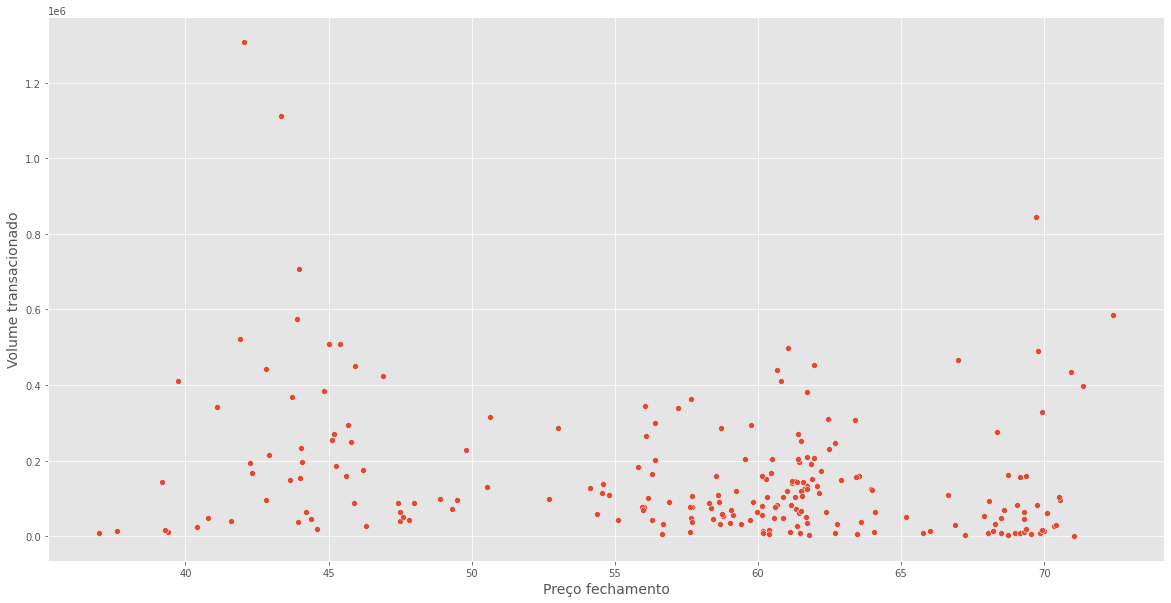

In [26]:
ax=sns.scatterplot(x="Close", y="Volume", data=df)
ax.set_xlabel('Preço fechamento', fontsize=14)
ax.set_ylabel('Volume transacionado', fontsize=14)
ax=ax

###Statsmodels

A tendência refere-se ao movimento de uma série para valores relativamente mais altos ou mais baixos durante um longo período de tempo.

A sazonalidade refere-se a um padrão repetitivo dentro de um período de tempo fixo.

O ruído ou irregularidade é alguma forma de variação aleatória dentro da time series


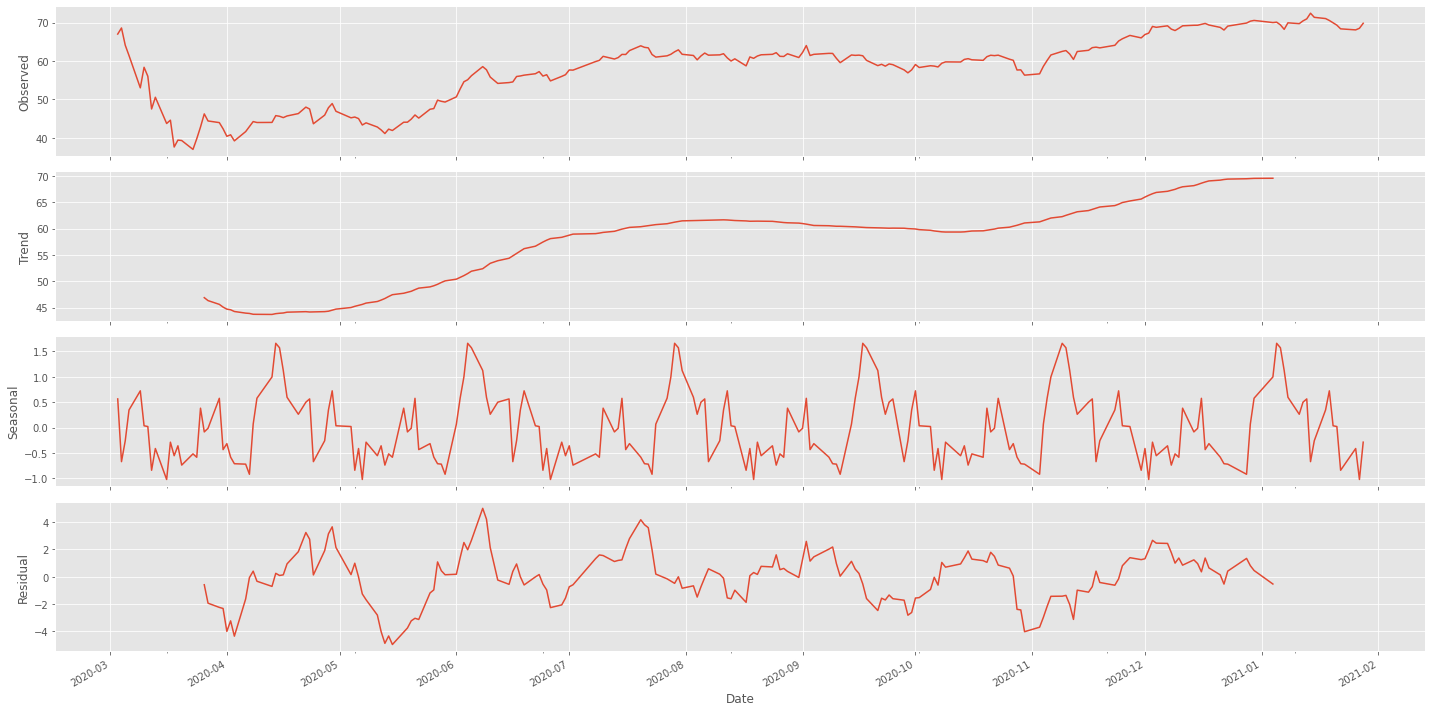

In [27]:
resultado = seasonal_decompose(df['Close'], freq=35)
ax = resultado.plot()

In [28]:
'''observacao = resultado.observed
tendencia = resultado.trend
sazonalidade = resultado.seasonalmatrix confusion
ruido = resultado.resid'''

'observacao = resultado.observed\ntendencia = resultado.trend\nsazonalidade = resultado.seasonalmatrix confusion\nruido = resultado.resid'

##decomposição
para verificar variação dos preços de um dia para o outro

In [29]:
df['variacao'] = df['Close'].diff()
df.head()

,High,Low,Open,Close,Volume,Date,variacao
Date,,,,,,,
2020-03-03,69.419998,66.540001,67.599998,66.989998,466850.0,2020-03-03,NaN
2020-03-04,68.699997,67.360001,68.500000,68.580002,67950.0,2020-03-04,1.590004
2020-03-05,68.099998,63.490002,68.099998,64.089996,62710.0,2020-03-05,-4.490005
2020-03-06,63.000000,60.840000,63.000000,61.400002,269020.0,2020-03-06,-2.689995
2020-03-09,58.000000,53.000000,58.000000,53.000000,287250.0,2020-03-09,-8.400002


##função de plot

In [30]:
def plotar (titulo, labelx, labely, x, y, dataset):
    sns.set_palette('Accent')
    sns.set_style('darkgrid')
    ax = sns.lineplot(x=x, y=y, data=dataset)
    ax.figure.set_size_inches(12,6)
    ax.set_title(titulo, loc='left', fontsize=18)
    ax.set_xlabel(labelx, fontsize=14)
    ax.set_ylabel(labely, fontsize=14)
    ax = ax

criando função de plot de graficos para comparação

In [31]:
def plot_comparacao(x, y1, y2, dataset1, dataset2, titulo):
    plt.figure(figsize=(16,12))
    ax = plt.subplot(2,1,1)
    ax.set_title(titulo,fontsize=18, loc='left')
    sns.lineplot(x=x, y=y1, data=dataset1)
    plt.subplot(2,1,2)
    sns.lineplot(x=x, y=y2, data=dataset2)
    ax=ax

In [32]:
def plot_comparacao3(x, y1, y2, y3, dataset1, dataset2, dataset3, titulo):
    plt.figure(figsize=(16,12))
    ax = plt.subplot(3,1,1)
    ax.set_title(titulo,fontsize=18, loc='left')
    sns.lineplot(x=x, y=y1, data=dataset1)
    plt.subplot(3,1,2)
    sns.lineplot(x=x, y=y2, data=dataset2)
    plt.subplot(3,1,3)
    sns.lineplot(x=x, y=y3, data=dataset3)
    ax=ax

##Análise comparativa da variação de preço

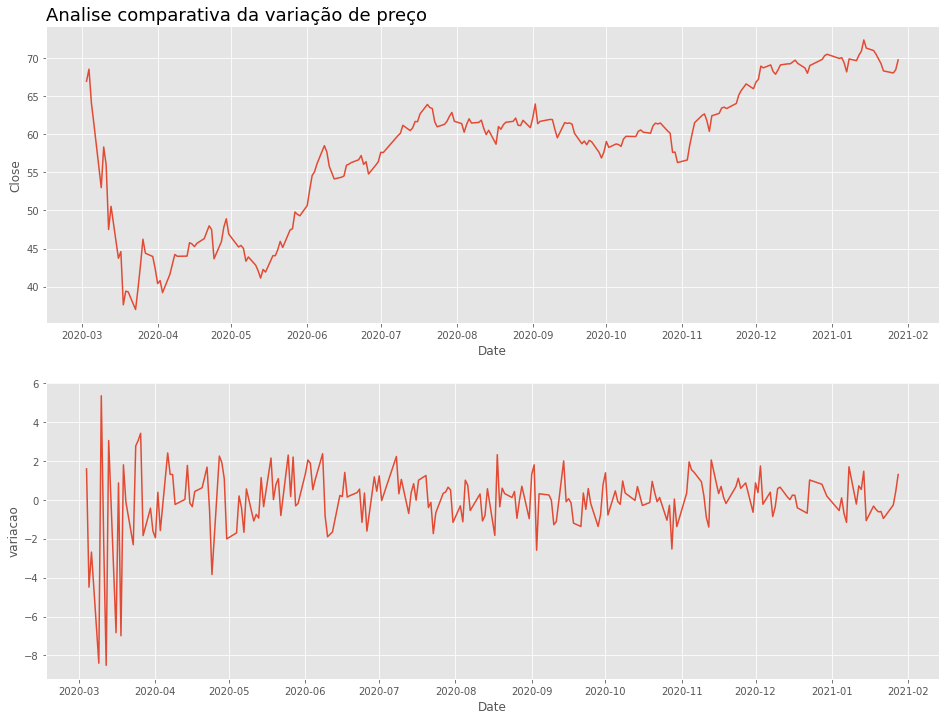

In [33]:
plot_comparacao('Date', 'Close', 'variacao', df, df, 'Analise comparativa da variação de preço ')

Ao analisarmos o gráfico podemos perceber uma tedência na nossa série, além de uma grande discrepância entre os valores observados.

Para solucionarmos o problema da diferença entre os valores, vamos usar uma técnica de normalização.

#Pré-Processamento dos Dados

deixam dados no formato de uma Série Temporal

In [34]:
df.index = df["Date"]
df = df["Close"]

In [35]:
df.tail()

Date
2021-01-21    69.309998
2021-01-22    68.349998
2021-01-26    68.080002
2021-01-27    68.500000
2021-01-28    69.800003
Name: Close, dtype: float64

##Normalização

In [36]:
dataset = df.values.reshape((-1,1))
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)

#LSTM

![alt text](https://miro.medium.com/max/700/1*goJVQs-p9kgLODFNyhl9zA.gif)

#Máquina Preditiva: Construção da LSTM

Predição preço de ações utilizando Long-Short Term Memory



Processo de modelagem (tomada de decisão):

1) Quantidade de observações do passado utilizar para estimarmos o valor futuro.

2) Quantidades quantos passos à frente vamos querer estimar.

In [37]:
look_back = 5
future_target = 1

Divisão do dataset em treino e teste

In [38]:
tam = int(len(dataset) * 0.70)
dataset_teste = dataset[tam:]
dataset_treino = dataset[:tam]

Por padrão, Redes Neurais necessitam que os dados de input estejam na forma matricial, de preferência uma matriz tridimensional (sample, timestep, feature).

Função de transformação dos dados: reshape


In [39]:
def process_data(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [40]:
X, y = process_data(dataset_treino,look_back,future_target)
y = np.array([list(a.ravel()) for a in y])

x_test, y_test = process_data(dataset_teste,look_back,future_target)
y_test = np.array([list(a.ravel()) for a in y_test])

In [41]:
X[0]

array([[0.84678328],
       [0.89164795],
       [0.76495479],
       [0.689052  ],
       [0.45203163]])

In [42]:
y[0]

array([0.60299096])

Separação do conjunto de dados de teste e separar um porcentagem para validação.

In [43]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

Construção da rede neural com paramêtros padrões e treino

In [44]:
#Definindo os números de neurônios por camada
n_first = 128
EPOCHS = 50

In [45]:
'''adam = keras.optimizers.Adam(lr=0.0001)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss'), 
             keras.callbacks.ModelCheckpoint(filepath='melhor_modelo.hdf5', 
                                  monitor='val_loss', save_best_only=True)]   '''


"adam = keras.optimizers.Adam(lr=0.0001)\nopt = tf.keras.optimizers.RMSprop(learning_rate=0.1)\n\ncallbacks = [keras.callbacks.EarlyStopping(monitor='val_loss'), \n             keras.callbacks.ModelCheckpoint(filepath='melhor_modelo.hdf5', \n                                  monitor='val_loss', save_best_only=True)]   "

In [46]:
#Construido o modelo
model = Sequential()
model.add(LSTM(n_first,input_shape = (look_back,1)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')



In [47]:
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=False,batch_size=2, verbose=2)

Epoch 1/50
60/60 - 3s - loss: 0.0324 - val_loss: 0.0052
Epoch 2/50
60/60 - 0s - loss: 0.0105 - val_loss: 0.0039
Epoch 3/50
60/60 - 0s - loss: 0.0098 - val_loss: 0.0038
Epoch 4/50
60/60 - 0s - loss: 0.0077 - val_loss: 0.0035
Epoch 5/50
60/60 - 0s - loss: 0.0092 - val_loss: 0.0037
Epoch 6/50
60/60 - 0s - loss: 0.0077 - val_loss: 0.0034
Epoch 7/50
60/60 - 0s - loss: 0.0089 - val_loss: 0.0033
Epoch 8/50
60/60 - 0s - loss: 0.0095 - val_loss: 0.0033
Epoch 9/50
60/60 - 0s - loss: 0.0085 - val_loss: 0.0033
Epoch 10/50
60/60 - 0s - loss: 0.0077 - val_loss: 0.0031
Epoch 11/50
60/60 - 0s - loss: 0.0076 - val_loss: 0.0032
Epoch 12/50
60/60 - 0s - loss: 0.0084 - val_loss: 0.0035
Epoch 13/50
60/60 - 0s - loss: 0.0075 - val_loss: 0.0035
Epoch 14/50
60/60 - 0s - loss: 0.0065 - val_loss: 0.0030
Epoch 15/50
60/60 - 0s - loss: 0.0066 - val_loss: 0.0043
Epoch 16/50
60/60 - 0s - loss: 0.0069 - val_loss: 0.0029
Epoch 17/50
60/60 - 0s - loss: 0.0061 - val_loss: 0.0035
Epoch 18/50
60/60 - 0s - loss: 0.0059 - 

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


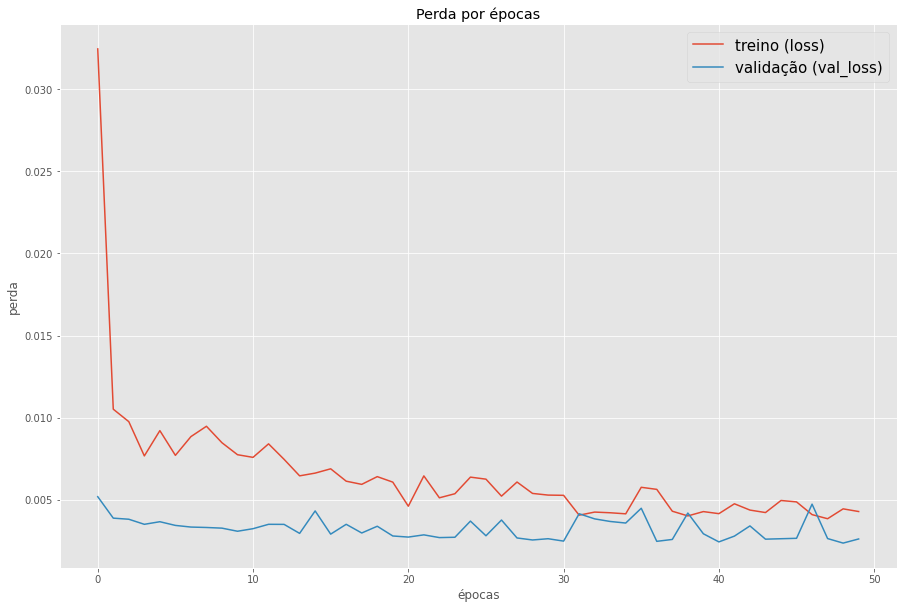

In [49]:
#Gráfico do resultado da função perda por epochs
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Perda por épocas')
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino (loss)', 'validação (val_loss)'], loc='best',fontsize=15)
plt.show()

In [50]:
#Salvando os valores preditos
prediction = model.predict(x_test)

prediction_inverse = scaler.inverse_transform(prediction)

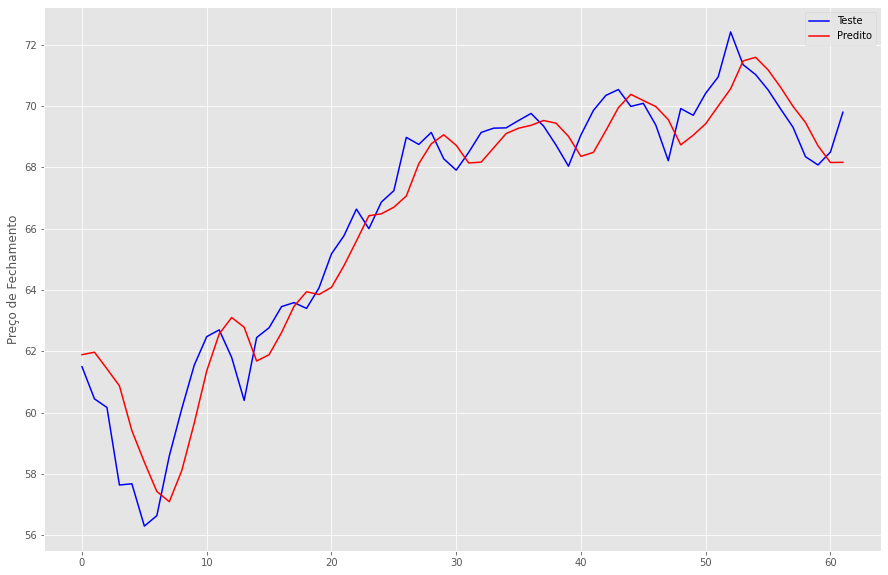

In [51]:
plt.figure(figsize = (15,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)),c='b', label='Teste')
plt.plot(scaler.inverse_transform(prediction.reshape(-1,1)), c='r',label='Predito')
plt.ylabel("Preço de Fechamento")
plt.legend(loc='best')
plt.show()

##salvando o modelo

In [52]:
model.save('modelo.h5')
#model_salvo = load_model('modelo.h5')

In [53]:
#model.get_config()

#Máquina Preditiva: Stacked Long-Short Term Memory networks



In [54]:
model2 = Sequential()

# input_shape : (X_train.shape[1] = timestep = 10, X_train.shape[2] = feature = 1)
model2.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model2.add(Dropout(0.25))

model2.add(LSTM(50, return_sequences=True))
model2.add(Dropout(0.20))

model2.add(LSTM(50))
model2.add(Dropout(0.20))

model2.add(Dense(1))

model2.summary()

model2.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 100)            40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [55]:
model2.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
2/2 [==============================] - 5s 21ms/step - loss: 0.2719
Epoch 2/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2226
Epoch 3/50
2/2 [==============================] - 0s 19ms/step - loss: 0.1984
Epoch 4/50
2/2 [==============================] - 0s 17ms/step - loss: 0.1554
Epoch 5/50
2/2 [==============================] - 0s 18ms/step - loss: 0.1010
Epoch 6/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0534
Epoch 7/50
2/2 [==============================] - 0s 17ms/step - loss: 0.0214
Epoch 8/50
2/2 [==============================] - 0s 17ms/step - loss: 0.0271
Epoch 9/50
2/2 [==============================] - 0s 17ms/step - loss: 0.0493
Epoch 10/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0405
Epoch 11/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0237
Epoch 12/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0158
Epoch 13/50
2/2 [==============================] - 0s 17ms/st

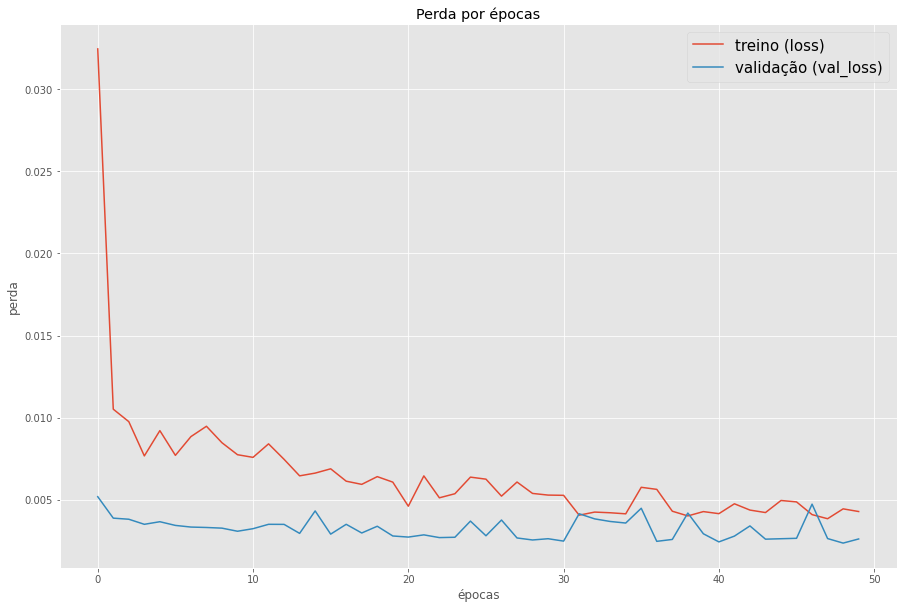

In [56]:
#Gráfico do resultado da função perda por epochs
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Perda por épocas')
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino (loss)', 'validação (val_loss)'], loc='best',fontsize=15)
plt.show()

In [57]:
prediction2 = model2.predict(x_test)

prediction2_inverse = scaler.inverse_transform(prediction2)

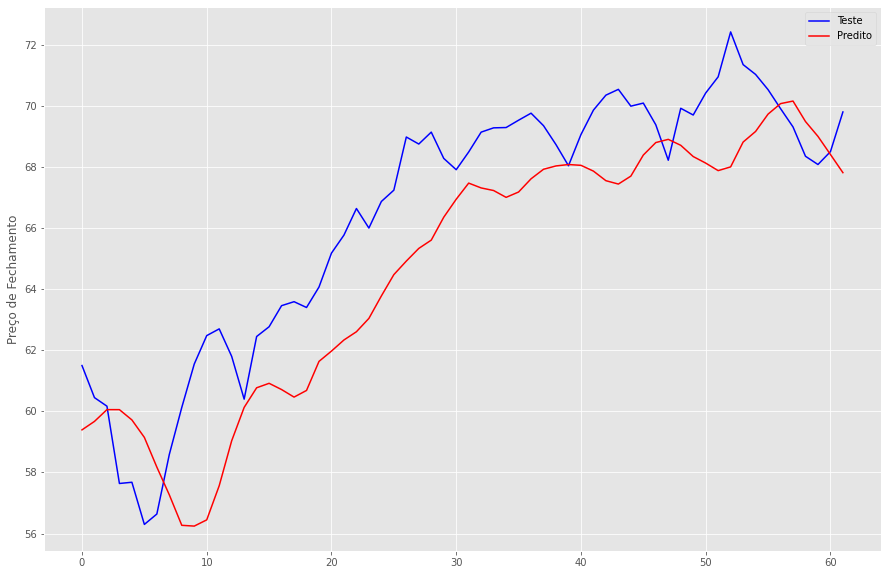

In [58]:
plt.figure(figsize = (15,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)),c='b', label='Teste')
plt.plot(scaler.inverse_transform(prediction2.reshape(-1,1)), c='r',label='Predito')
plt.ylabel("Preço de Fechamento")
plt.legend(loc='best')
plt.show()

In [59]:
#Salvando e carregando o modelo treinado

model2.save('modelo2.h5')
model2_salvo = load_model('modelo2.h5')

#Avaliando o modelo da Máquina Preditiva



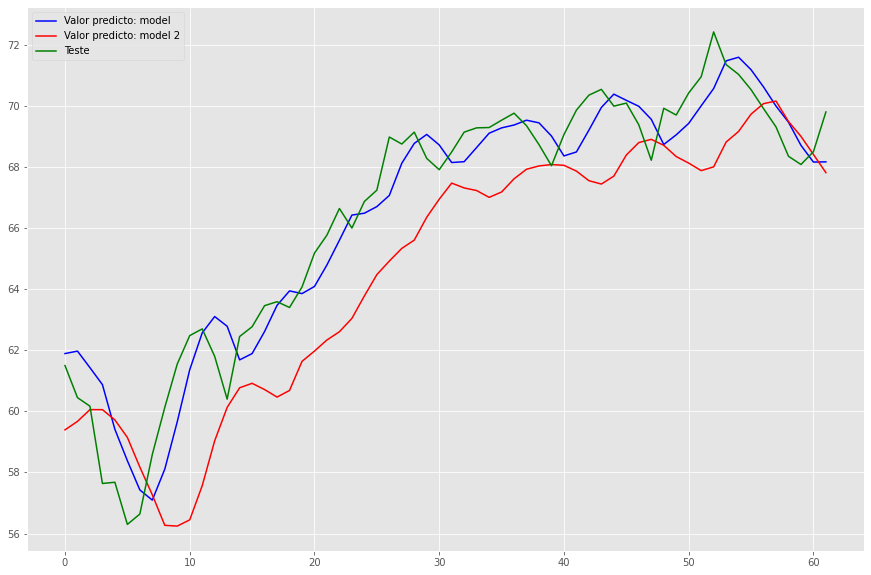

Mean Squared Error model:  4306.960632534962
Mean Squared Error model2:  4089.130458768318


In [60]:
#model x model2

plt.figure(figsize=(15,10))
plt.plot(prediction_inverse, color='blue', label='Valor predicto: model')
plt.plot(prediction2_inverse, color='red', label='Valor predicto: model 2')
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)),c='g', label='Teste')
plt.legend()
plt.show()

print('Mean Squared Error model: ', mean_squared_error(y_test, prediction_inverse))
print('Mean Squared Error model2: ', mean_squared_error(y_test, prediction2_inverse))

In [61]:
# Avaliação do model nos dados de teste usando 'evaluate'
print("Model: usando evaluate nos dados de teste")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Avaliação do model2 nos dados de teste usando 'evaluate'
print("\nModel2: usando evaluate nos dados de teste")
results2 = model2.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results2)



Model: usando evaluate nos dados de teste
1/1 [==============================] - 0s 416ms/step - loss: 9.7126e-04
test loss, test acc: 0.0009712550090625882

Model2: usando evaluate nos dados de teste
1/1 [==============================] - 1s 1s/step - loss: 0.0051
test loss, test acc: 0.005135293118655682


#Sprint 3: back-end do protótipo

modular em componentes


#Sprint 4: front-end do protótipo
deploy
